<a href="https://colab.research.google.com/github/LaZoark/FaultNet/blob/main/%5BAE_Clf%5DBearing_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare the environment

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda:0


## Choose the dataset

In [1]:
DATASET = 'CWRU'    # From FaultNet. More info please visit http://manufacturingnet.io/html/datasets.html
DATASET = 'JNU'     # Jiangnan University 江南大學軸承資料集
# DATASET = 'BComp'   # Bearing Competition 軸承競賽
# DATASET = 'CWRU2'   # 凱斯西儲大學

### Additional Functions (Not essential for the `model` and `training`)

In [3]:
### This is for TensorBoard
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard
writer = SummaryWriter('/content/logsdir', comment=f'{DATASET}_LogSoftmax')

### These are ONLY required by torchviz for plotting the graph
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

### Help print the PyTorch model info like Keras does
!pip install torchinfo -qq
### Help visualize the PyTorch model graph
!pip install torchviz -qq

## Download and decompress the dataset

In [4]:
import os
ds_list = ['CWRU.zip', 'JNU_Preprocessing.rar', 'BComp_Preprocessing.rar', 'CWRU_Preprocessing.rar']

if DATASET == 'CWRU':     # size(2800, 1600)  , 10 classes
  if not os.path.exists(f'{os.getcwd()}/{ds_list[0]}'):
    !wget https://github.com/LaZoark/FaultNet/raw/main/CWRU.zip
    !unzip /content/CWRU.zip
elif DATASET == 'JNU':    # size(1200, 5005)  , 12 classes
  if not os.path.exists(f'{os.getcwd()}/{ds_list[1]}'):
    !wget https://github.com/LaZoark/FaultNet/raw/main/Preprocessing/JNU_Preprocessing.rar
    !unrar e /content/JNU_Preprocessing.rar
elif DATASET == 'BComp':  # size( 792, 6000)  , 10 classes
  if not os.path.exists(f'{os.getcwd()}/{ds_list[2]}'):
    !wget https://github.com/LaZoark/FaultNet/raw/main/Preprocessing/BComp_Preprocessing.rar
    !unrar e /content/BComp_Preprocessing.rar
elif DATASET == 'CWRU2':  # size(4600, 1024)  , 10 classes
  if not os.path.exists(f'{os.getcwd()}/{ds_list[3]}'):
    !wget https://github.com/LaZoark/FaultNet/raw/main/Preprocessing/CWRU_Preprocessing.rar
    !unrar e /content/CWRU_Preprocessing.rar

# Prepare the dataset

In [5]:
if DATASET == 'CWRU':     # size(2800, 1600)  , 10 classes
  data = np.load('/content/CWRU files/signal_data.npy')
  labels = np.load('/content/CWRU files/signal_data_labels.npy')
  real_labels = ['Normal', 'B007', 'B014', 'B021', 'IR007', 'IR014', 'IR021', 'OR007', 'OR014', 'OR021']
  fault_amount = 10
  x = data[:, 0:1600]
  _size = 40

elif DATASET == 'JNU':    # size(1200, 5005)  , 12 classes
  data = np.load('/content/JNU_dataset.npy')
  labels = np.load('/content/JNU_labels.npy', allow_pickle=True)
  real_labels = list(set(labels))     # Since it already comes with real fault-name, no need to code it manually
  real_labels.sort()
  fault_amount = 12
  x = data[:, 0:4900]
  _size = 70

elif DATASET == 'BComp':  # size( 792, 6000)  , 10 classes
  data = np.load('/content/BComp_dataset.npy')
  labels = np.load('/content/BComp_labels.npy', allow_pickle=True)
  real_labels = ['Normal', 'OR_1', 'IR_1', 'B_1', 'OR_2', 'IR_2', 'B_2', 'OR_3', 'IR_3', 'B_3']
  fault_amount = 10
  x = data[:, 0:5929]
  _size = 77

elif DATASET == 'CWRU2':  # size(4600, 1024)  , 10 classes
  data = np.load('/content/CWRU_dataset.npy')
  labels = np.load('/content/CWRU_labels.npy', allow_pickle=True, )
  real_labels = list(set(labels))     # Since it already comes with real fault-name, no need to code it manually
  real_labels.sort()
  fault_amount = 10
  x = data[:, 0:1024]
  _size = 32

## Show the data and its amount

In [6]:
label_encoder = lambda i: real_labels[i]
### Encode the labels (Mapping number to string)
### to show the chart with real labels
### Will reverse after this chart
if DATASET != 'JNU' and DATASET != 'CWRU2':
  k = []
  for item in labels.astype('int'):
    item = label_encoder(item)
    k.append(item)
  labels = np.array(k)

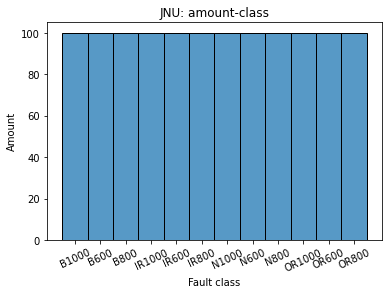

In [7]:
import seaborn as sns
fig, ax = plt.subplots()
fig = sns.histplot(data=labels, kde=False, stat='count', discrete=True, palette='coolwarm', multiple='stack', ax=ax)
# fig = sns.histplot(data=labels, x=real_labels, kde=False, stat='count', discrete=True, palette='coolwarm', multiple='stack', ax=ax)
# ax.set_xlim(0, 9)
# ax.set_ylim(0, 300)
ax.set_xlabel("Fault class")
ax.set_ylabel("Amount")
ax.set_title(f"{DATASET}: amount-class")
for item in fig.get_xticklabels():
  item.set_rotation(25)
plt.show()

## Encode the labels (Mapping string to number)

In [ ]:
map_dict = {}
i = 0
k = []
for item in labels:
  if i > 0 and item in map_dict:
    continue
  else:    
    map_dict[item] = i
    i += 1
  k.append(map_dict[item])
labels = np.array(k)

print(real_labels)
print(labels[:20])

In [8]:
# map_dict = {}
# i = 0
# for item in labels:
#   if i>0 and item in map_dict:
#     continue
#   else:    
#     map_dict[item] = i
#     i += 1

# k = []
# for item in labels:
#   k.append(map_dict[item])
# labels = np.array(k)

# print(real_labels)
# print(labels[:20])

['B1000', 'B600', 'B800', 'IR1000', 'IR600', 'IR800', 'N1000', 'N600', 'N800', 'OR1000', 'OR600', 'OR800']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## Make up the dataset

In [9]:
def mean(data, no_elements=10):
  X = np.zeros((data.shape[0], data.shape[1]))
  for i in range(data.shape[1] - no_elements + 1):
    X[:, i] = np.mean(data[:, i:i+no_elements], axis=1)
  return X.astype(np.float16)
def median(data, no_elements=10):
  X = np.zeros((data.shape[0], data.shape[1]))
  for i in range(data.shape[1] - no_elements + 1):
    X[:, i] = np.median(data[:, i:i+no_elements], axis=1)
  return X.astype(np.float16)
def sig_image(data, size):
  X = np.zeros((data.shape[0], size, size))
  for i in range(data.shape[0]):
    X[i] = (data[i, :].reshape(size, size))
  return X.astype(np.float16)

### According to the Paper(FaultNet), the input is consist of three channels
channel_mean = (mean(x, fault_amount)).astype(np.float16)
x_m = sig_image(channel_mean, _size)
print(f'x_m:\t{x_m.shape}')
channel_median = (median(x, fault_amount)).astype(np.float16)
# x_md = sig_image(x, _size)
x_md = sig_image(channel_median, _size)
print(f'x_md:\t{x_md.shape}')
x_n = sig_image(x, _size)
print(f'x_n:\t{x_n.shape}')
X = np.stack((x_n, x_m, x_md), axis=1).astype(np.float16)
print(f'X:\t{X.shape}')

x_m:	(1200, 70, 70)
x_md:	(1200, 70, 70)
x_n:	(1200, 70, 70)
X:	(1200, 3, 70, 70)


In [10]:
from sklearn.model_selection import train_test_split
trainx, testx, trainlabel, testlabel = train_test_split(X, labels, test_size=0.2, random_state=20)
sig_train, sig_test = trainx, testx
lab_train, lab_test = trainlabel, testlabel
sig_train = torch.from_numpy(sig_train)
sig_test = torch.from_numpy(sig_test)
lab_train = torch.from_numpy(lab_train)
lab_test = torch.from_numpy(lab_test)

In [11]:
print(f'Train set: {sig_train.size()}')
print(f'Test set:  {sig_test.size()}')

Train set: torch.Size([960, 3, 70, 70])
Test set:  torch.Size([240, 3, 70, 70])


### Data Loader for training/testing

In [12]:
import torch.utils.data as data_utils
# batch_size = 128
batch_size = 64
train_tensor = data_utils.TensorDataset(sig_train, lab_train)
train_loader = data_utils.DataLoader(dataset=train_tensor, batch_size=batch_size, shuffle=True)

In [13]:
batch_size = 1024
test_tensor = data_utils.TensorDataset(sig_test, lab_test)
test_loader = data_utils.DataLoader(dataset=test_tensor, batch_size=batch_size, shuffle=False)

# `Model` AutoEncoder with Classifier

In [14]:
class AE_Classifier(nn.Module):
  def __init__(self, n_embedded, input_size=_size, _dim=4):
    super(AE_Classifier, self).__init__()
    self.encoder = nn.Sequential(
      nn.Linear(input_size, _dim*16),
      nn.ReLU(),
      nn.Linear(_dim*16, _dim*8),
      nn.ReLU(),
      nn.Linear(_dim*8, _dim*4),
      nn.ReLU(),
      nn.Linear(_dim*4, n_embedded),
    )
    self.decoder = nn.Sequential(
      nn.Linear(n_embedded, _dim*4),
      nn.ReLU(),
      nn.Linear(_dim*4, _dim*8),
      nn.ReLU(),
      nn.Linear(_dim*8, _dim*16),
      nn.ReLU(),
      nn.Linear(_dim*16, input_size),
    )
    self.classifier = nn.Sequential(
      nn.Linear(input_size*3*n_embedded, input_size*n_embedded),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(input_size*n_embedded, input_size*n_embedded),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(input_size*n_embedded, 3*n_embedded),
      ###====== 分類器新增了BN，實驗顯示如此可使預測分數更穩定 ======###
      nn.BatchNorm1d(num_features=3*n_embedded),
      ###====== 分類器新增了BN，實驗顯示如此可使預測分數更穩定 ======###
      # nn.ReLU(),
      # nn.Dropout(0.2),
      nn.Linear(3*n_embedded, len(real_labels)),
      nn.LogSoftmax(dim=-1)
    )
    
  def forward(self, x):
    # batch_size = x.shape[0]
    ### flatten
    # x = x.reshape(batch_size, 17787)

    # in_size = x.size(0)
    # print(x.shape)
    # print("this is in_size", in_size)
    # x = x.view(in_size, -1)
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    # print(encoded.shape)        #out#: torch.Size([128, 3, 77, 256])
    encoded = encoded.view(encoded.size(0), -1)
    # print(encoded.shape)        #out#: torch.Size([128, 59136])
    clf_out = self.classifier(encoded)
    # print("clf_out: ", clf_out.shape)   #clf_out#:  torch.Size([128, 3, 77, 10])
    # clf_out = clf_out.view(clf_out.size(0), -1)
    # print("clf_out: ", clf_out.shape)   #out#:  torch.Size([128, 2310])
    return decoded, clf_out, encoded

  # def forward(self, x):
  #     in_size = x.size(0)
  #     x = F.relu(self.mp1(self.conv1(x)))
  #     x = F.relu(self.mp2(self.conv2(x)))
  #     # print(x.shape)
  #     x = x.view(in_size, -1) # CWRU
  #     # x = x.view(-1, sig_train.size()[0]-64) # JNU
  #     x = F.relu(self.fc1(x))
  #     x = self.dp1(x)
  #     x = self.fc2(x)
      
  #     return F.log_softmax(x, dim=1)

# model = AE_Classifier(10, _dim=4)
model = AE_Classifier(fault_amount, _dim=4)
model.to(device)
print(model)

AE_Classifier(
  (encoder): Sequential(
    (0): Linear(in_features=70, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=70, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2520, out_features=840, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=840, out_features=840, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=840, out_features=36, bias=True)
    (7): BatchNorm1d(36, ep

## Details

In [15]:
from torchinfo import summary
b_size = 128
summary(model, input_size=(b_size, 3, _size, _size))   # e.g. (64, 3, 70, 70)

Layer (type:depth-idx)                   Output Shape              Param #
AE_Classifier                            [128, 3, 70, 70]          --
├─Sequential: 1-1                        [128, 3, 70, 12]          --
│    └─Linear: 2-1                       [128, 3, 70, 64]          4,544
│    └─ReLU: 2-2                         [128, 3, 70, 64]          --
│    └─Linear: 2-3                       [128, 3, 70, 32]          2,080
│    └─ReLU: 2-4                         [128, 3, 70, 32]          --
│    └─Linear: 2-5                       [128, 3, 70, 16]          528
│    └─ReLU: 2-6                         [128, 3, 70, 16]          --
│    └─Linear: 2-7                       [128, 3, 70, 12]          204
├─Sequential: 1-2                        [128, 3, 70, 70]          --
│    └─Linear: 2-8                       [128, 3, 70, 16]          208
│    └─ReLU: 2-9                         [128, 3, 70, 16]          --
│    └─Linear: 2-10                      [128, 3, 70, 32]          544
│    

## Training 

In [16]:
criterion_AE = nn.MSELoss()
criterion_clf = nn.CrossEntropyLoss()
# optimizer = Adam(model.parameters(), lr=0.001)
optimizer = Adam(model.parameters(), lr=0.0005)
if torch.cuda.is_available():
  num_epochs = 100
else:
  num_epochs = 70

total_step = len(train_loader)
loss_list = []
acc_list = []
loss_list_AE = []
loss_list_clf = []

model.train()

for epoch in range(num_epochs):
  for i, (signals, labels) in enumerate(train_loader):
    # Reset the model gradient
    # model.zero_grad()
    optimizer.zero_grad()
    # Run the forward pass
    signals = signals.to(device)
    labels = labels.to(device)
    # print(signals.shape)
    decoded, clf_out, encoded = model(signals.float())   ##RuntimeError: expected scalar type Half but found Float
    # decoded, clf_out = model(signals)
    loss_AE = criterion_AE(decoded, signals.float())  ##RuntimeError: Found dtype Half but expected Float
    # loss_clf = criterion_clf(clf_out, labels)
    loss_clf = criterion_clf(clf_out, labels.long())  ##RuntimeError: Found dtype Half but expected Float
    # loss_clf = criterion_clf(clf_out[:, -1, -1, :], labels.long())
    # loss_clf = criterion_clf(clf_out[:, -1, -1, -1], labels.long())
    loss = loss_AE + loss_clf
    loss_list.append(loss.item())
    loss_list_AE.append(loss_AE.item())
    loss_list_clf.append(loss_clf.item())

    # Backprop and perform Adam optimisation
    loss.backward()
    optimizer.step()
    # Track the accuracy
    total = labels.size(0)
    _,  predicted = torch.max(clf_out.data, 1)
    correct = (predicted == labels.long()).sum().item()
    # correct = (predicted == signals.double()).sum().item()
    acc_list.append(correct / total)

    if (epoch+1)%5==0 or epoch==0:
      print(f'Epoch [{epoch+1:2}/{num_epochs}], Step [{i+1:2}/{total_step}],  Loss: {loss.item():<7.2f}, '
            f'Loss_AE: {loss_AE.item():<7.3f}, Loss_clf: {loss_clf.item():<7.3f}, Train Accuracy: {(correct/total)*100:>5.2f}%')

  writer.add_scalar("MSELoss", loss_AE.item(), epoch)
  writer.add_scalar("CrossEntropyLoss", loss_clf.item(), epoch)
  writer.add_scalar("Accuracy", (correct/total)*100, epoch)

Epoch [ 1/100], Step [ 1/15],  Loss: 2.74   , Loss_AE: 0.065  , Loss_clf: 2.675  , Train Accuracy:  6.25%
Epoch [ 1/100], Step [ 2/15],  Loss: 2.66   , Loss_AE: 0.067  , Loss_clf: 2.588  , Train Accuracy:  6.25%
Epoch [ 1/100], Step [ 3/15],  Loss: 2.80   , Loss_AE: 0.057  , Loss_clf: 2.744  , Train Accuracy:  3.12%
Epoch [ 1/100], Step [ 4/15],  Loss: 2.78   , Loss_AE: 0.064  , Loss_clf: 2.719  , Train Accuracy: 10.94%
Epoch [ 1/100], Step [ 5/15],  Loss: 2.73   , Loss_AE: 0.060  , Loss_clf: 2.665  , Train Accuracy:  9.38%
Epoch [ 1/100], Step [ 6/15],  Loss: 2.74   , Loss_AE: 0.076  , Loss_clf: 2.664  , Train Accuracy: 10.94%
Epoch [ 1/100], Step [ 7/15],  Loss: 2.70   , Loss_AE: 0.062  , Loss_clf: 2.637  , Train Accuracy: 10.94%
Epoch [ 1/100], Step [ 8/15],  Loss: 2.92   , Loss_AE: 0.062  , Loss_clf: 2.853  , Train Accuracy:  7.81%
Epoch [ 1/100], Step [ 9/15],  Loss: 2.77   , Loss_AE: 0.058  , Loss_clf: 2.714  , Train Accuracy:  4.69%
Epoch [ 1/100], Step [10/15],  Loss: 2.71   , 

In [17]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=1)
#         self.mp1 = nn.MaxPool2d(kernel_size=4, stride=2)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=1)
#         self.mp2 = nn.MaxPool2d(kernel_size=4, stride=2)
#         if DATASET == 'CWRU':
#           self.fc1= nn.Linear(2304, 256)
#         elif DATASET == 'JNU':
#           self.fc1= nn.Linear(64*14*14, 256)
#         elif DATASET == 'BComp':
#           self.fc1= nn.Linear(64*16*16, 256)
#         elif DATASET == 'CWRU2':
#           self.fc1= nn.Linear(64*4*4, 256)
#         self.dp1 = nn.Dropout(p=0.2)
#         self.fc2 = nn.Linear(256, len(real_labels))

#     def forward(self, x):
#         in_size = x.size(0)
#         x = F.relu(self.mp1(self.conv1(x)))
#         x = F.relu(self.mp2(self.conv2(x)))
#         # print(x.shape)
#         x = x.view(in_size, -1) # CWRU
#         # x = x.view(-1, sig_train.size()[0]-64) # JNU
#         x = F.relu(self.fc1(x))
#         x = self.dp1(x)
#         x = self.fc2(x)
        
#         return F.log_softmax(x, dim=1)

# model = CNN().double()
# model.to(device)
# print(model)

In [18]:
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# # num_epochs = 100
# num_epochs = 50
# total_step = len(train_loader)
# loss_list = []
# acc_list = []
# for epoch in range(num_epochs):
#     for i, (signals, labels) in enumerate(train_loader):
#         optimizer.zero_grad()
#         # Run the forward pass
#         signals = signals.to(device)
#         labels = labels.to(device)
#         outputs = model(signals.double())
#         loss = criterion(outputs, labels.long())
#         # loss = criterion(outputs, signals.double())
        
#         loss_list.append(loss.item())

#         # Backprop and perform Adam optimisation
        
#         loss.backward()
#         optimizer.step()
#         # Track the accuracy
#         total = labels.size(0)
#         # total = signals.size(0)
#         _,  predicted = torch.max(outputs.data, 1)
#         correct = (predicted == labels.long()).sum().item()
#         # correct = (predicted == signals.double()).sum().item()
#         acc_list.append(correct / total)

#         if (epoch+1) % 5 == 0 or epoch==0:
#             print('Epoch [{}/{}],  Step [{}/{}],  Loss: {:.4f},  Train Accuracy: {:.2f}%'
#                   .format(epoch + 1,  num_epochs,  i + 1,  total_step,  loss.item(), 
#                           (correct / total) * 100))
        

### Loss and Accuracy
(Loss = MSE loss + CrossEntropy loss)

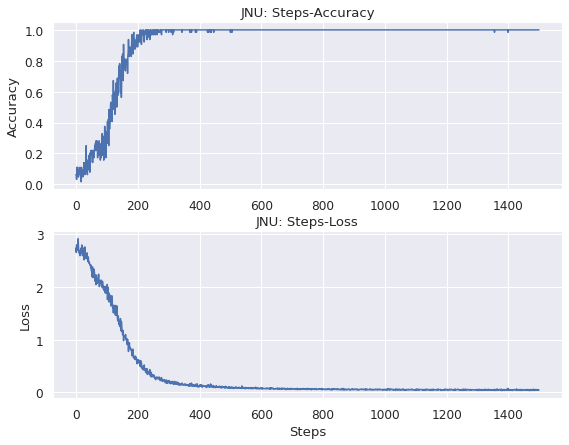

In [19]:
sns.set_theme(style="darkgrid", font_scale=1.1)
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
fig.tight_layout()
sns.lineplot(data=acc_list, ax=ax[0])

ax[0].set_ylabel("Accuracy")
ax[0].set_title(f"{DATASET}: Steps-Accuracy")
sns.lineplot(data=loss_list, ax=ax[1])
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Loss")
ax[1].set_title(f"{DATASET}: Steps-Loss")
plt.show()

### MSE and Cross-Entropy

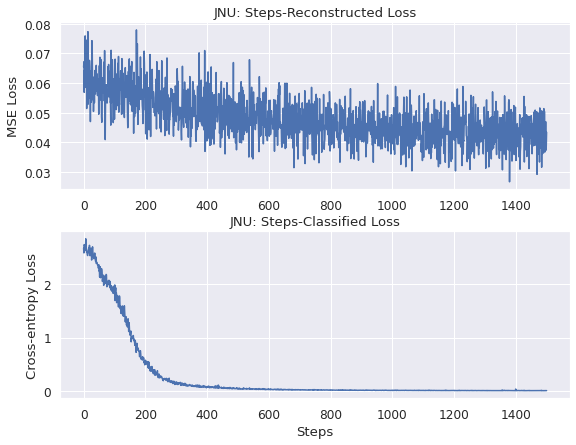

In [20]:
sns.set_theme(style="darkgrid", font_scale=1.1)
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
fig.tight_layout()
sns.lineplot(data=loss_list_AE, ax=ax[0])

ax[0].set_ylabel("MSE Loss")
ax[0].set_title(f"{DATASET}: Steps-Reconstructed Loss")
sns.lineplot(data=loss_list_clf, ax=ax[1])
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Cross-Entropy Loss")
ax[1].set_title(f"{DATASET}: Steps-Classified Loss")
plt.show()

## Testing

In [21]:
total_step = len(test_loader)
loss_list_test = []
acc_list_test = []
loss_list_AE_test = []
loss_list_clf_test = []
model.eval()
with torch.no_grad():
  for i,  (signals,  labels) in enumerate(test_loader):
    # Run the forward pass
    signals = signals.to(device)
    labels = labels.to(device)
    decoded, clf_out, encoded = model(signals.float())     ## for AE-clf
    loss_AE_test = criterion_AE(decoded, signals.float())
    loss_clf_test = criterion_clf(clf_out, labels.long())
    loss_test = loss_AE_test + loss_clf_test
    loss_list_test.append(loss_test.item())
    loss_list_AE_test.append(loss_AE_test.item())
    loss_list_clf_test.append(loss_clf_test.item())

    total = labels.size(0)
    _,  predicted = torch.max(clf_out.data, 1)
    correct = (predicted == labels.long()).sum().item()
    acc_list_test.append(correct / total)
    
    if (epoch) % 1 == 0:
      print(f'Loss: {loss_test.item():.4f}, Loss_AE: {loss_AE_test.item():.4f},'
            f'Loss_clf: {loss_clf_test.item():.4f}, Test Accuracy: {acc_list_test[-1]*100:.3f}%')

# Re-encode the labels (Mapping number to string)
k = []
for item in labels.cpu():
  item = label_encoder(item)
  k.append(item)
labels_str = np.array(k)

out = torch.cat((encoded.data, torch.ones(len(encoded), 1).to(device)), 1)
# need 3 dimension for tensor to visualize it!
writer.add_embedding(out, 
                    metadata = labels_str,
                    label_img = signals.data,
                    # label_img=decoded.data,
                    tag = f'{DATASET}_{acc_list_test[-1]*100:.3f}',
                    # global_step=2,
                    )
writer.close()

Loss: 0.3574, Loss_AE: 0.0416,Loss_clf: 0.3158, Test Accuracy: 91.667%


## Confusion Matrix

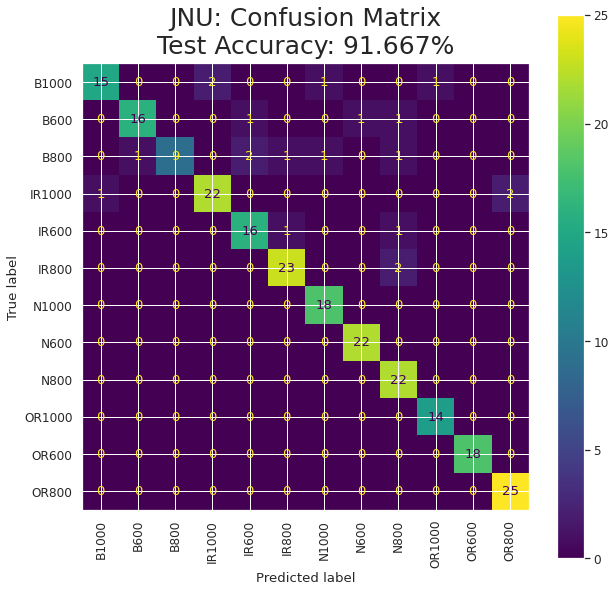

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels.cpu(), predicted.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=real_labels)
fig, ax = plt.subplots(figsize=(10, 10))
plt.title(f'{DATASET}: Confusion Matrix\nTest Accuracy: {acc_list_test[-1]*100:.3f}%', fontsize=25, pad=10)
disp.plot(xticks_rotation='vertical', ax=ax)

## Save the model

In [23]:
### Save the model as .pth
torch.save(model, f'{DATASET}_{(correct/total)*100:.3f}.pth')
### Store the confusion matrix as image to tensorboard
writer.add_figure(f'{DATASET}', fig)
### Store the model as graph to tensorboard
writer.add_graph(model, torch.randn(1, 3, _size, _size).to(device), verbose=False)
writer.close()

### Show the graph of the model

In [24]:
from torchviz import make_dot
model.cpu()
y = model(torch.randn(1, 3, _size, _size))
### save graph image
# make_dot(y, params=dict(list(model.named_parameters()))).render("AE_torchviz", format="png")
### plot graph
# make_dot(y, show_attrs=False, params=dict(list(model.named_parameters())))
### show attribute
# make_dot(y, show_attrs=True, params=dict(list(model.named_parameters())))

### Convert model (.pth) to ONNX
then use [Netron](https://netron.app/) to show the graph

In [25]:
model.eval()
input_names = [f'{DATASET}_bearing_signals']
output_names = ['output_names']
y = torch.randn(1, 3, _size, _size, requires_grad=True)
torch.onnx.export(model, y, f'AE_{DATASET}.onnx', export_params=False,
                  opset_version=10,
                  input_names=input_names,
                  output_names=output_names,
                  do_constant_folding=True,
                  dynamic_axes={input_names[-1]:{0:"batch_size"},
                                output_names[-1]:{0:"batch_size"}}
                  )

## TensorBoard

In [26]:
#======= If TensorBoard isn't working properly, try the following tricks. =======#
### Kill the tensorboard and start it again. It should work in colab or ubuntu.
# !kill <tensorboard's pid>
### (Optional) Flush the writer
# writer.flush()
### (Optional) Reload tensorboard
# %reload_ext tensorboard

In [27]:
### Start the tensorboard. The default port is 6006.
# %tensorboard --logdir /content/logsdir/ --reload_task auto